In [1]:
from qutip import *
import numpy as np
import scipy.optimize as sciop
import matplotlib.pyplot as plt
import cython
import skopt
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle

# define idealised basis
basis_labels = {
    'cav_bin': 0,
    'spont_bin': 1,
    'g':2,
    'u':3,
    'x':4
}
N=len(basis_labels)

g_ket = basis(N, basis_labels['g'])
u_ket = basis(N, basis_labels['u'])
x_ket = basis(N, basis_labels['x'])

# define basic operators
gx_swap = basis(N, basis_labels['g']) * basis(N, basis_labels['x']).dag()
ux_swap = basis(N, basis_labels['u']) * basis(N, basis_labels['x']).dag()

g_id = fock_dm(N, basis_labels['g'])
u_id = fock_dm(N, basis_labels['u'])
x_id = fock_dm(N, basis_labels['x'])
cav_id = fock_dm(N, basis_labels['cav_bin'])
spont_id = fock_dm(N, basis_labels['spont_bin'])

cav_decay = basis(N, basis_labels['cav_bin']) * basis(N, basis_labels['g']).dag()
spont_decay = basis(N, basis_labels['spont_bin']) * basis(N, basis_labels['x']).dag()

In [2]:
# define pulse shape
H_args = {}

sin_pulse = 'omega*np.sin(wSTIRAP*t)**2'

opts = Options(rhs_reuse=True)

In [3]:
# define parameters
gamma = 2*np.pi * 1
kappa = gamma * 1

# define collapse operators
c_ops = [np.sqrt(gamma)*spont_decay, np.sqrt(kappa)*cav_decay]

STEPS_PER_SEC = 1000


In [4]:
# define coordinates
NUM_COOPS = 25
g_min = np.sqrt(2*kappa/gamma)
g_max = 10*np.sqrt(4*kappa/gamma)

g_ratios = np.logspace(np.log10(g_min), np.log10(g_max), NUM_COOPS)

NUM_TIMES = 25
t_min = 0.1
t_max = 100

times = np.logspace(np.log10(t_min), np.log10(t_max), NUM_TIMES)

omega_guesses = [100]*len(g_ratios)
max_deltas = [20]*len(g_ratios)

current_time = t_min

In [5]:
omega_range_factor = 5
num_bayesian_calls = 50

def find_efficiency(g_ratio, omega, delta, time, psi0=u_ket, pulse_shape=sin_pulse):

    omega *= 2*np.pi
    delta *= 2*np.pi
    g0 = g_ratio * gamma

    H_args = {
        'omega': omega,
        'delta': delta,
        'g0': g0
    }

    global current_time
    
    if time != current_time:
        opts.rhs_reuse = False
        current_time = time

    # define time steps
    runtime = time/gamma
    H_args['T'] = runtime
    H_args['wSTIRAP'] = np.pi/runtime
    num_steps = round(STEPS_PER_SEC*runtime + 1)
    if num_steps < 1001:
        num_steps = 1001
    
    t_res = 2
    int_time = round(runtime, t_res)*10**t_res
    t = np.linspace(0, int_time, num_steps)
    t /= 10**t_res
    
    H0 = - g0*(gx_swap + gx_swap.dag())
    H1 = -1/2*(ux_swap + ux_swap.dag())
    H2 = g_id + u_id 
    H=[[H0,'g0'], [H1, pulse_shape], [H2, 'delta']]
    
    result = mesolve(H, psi0, t, c_ops, [], args=H_args, options=opts)
    
    photon_emission_prob = expect(cav_id, result.states[-1])
    
    opts.rhs_reuse = True

    return photon_emission_prob


def find_efficiency2(g_ratio, omega, time, psi0=u_ket, pulse_shape = sin_pulse):

    omega *= 2*np.pi
    g0 = g_ratio * gamma

    H_args = {
        'omega': omega,
        'g0': g0

    }

    global current_time
    
    if time != current_time:
        opts.rhs_reuse = False
        current_time = time

    # define time steps
    runtime = time/gamma
    H_args['T'] = runtime
    H_args['wSTIRAP'] = np.pi/runtime
    num_steps = round(STEPS_PER_SEC*runtime + 1)
    if num_steps < 1001:
        num_steps = 1001
    
    t_res = 2
    int_time = round(runtime, t_res)*10**t_res
    t = np.linspace(0, int_time, num_steps)
    t /= 10**t_res
    
    H0 = -(gx_swap + gx_swap.dag())
    H1 = -1/2*(ux_swap + ux_swap.dag())
    # H2 = g_id + u_id 
    H=[[H0, 'g0'], [H1, pulse_shape]]
    
    result = mesolve(H, psi0, t, c_ops, [], args=H_args, options=opts)
    
    photon_emission_prob = expect(cav_id, result.states[-1])
    
    opts.rhs_reuse = True

    return photon_emission_prob



def bayesian_optimiser(g_ratio, omega_guess, delta_max, time, n_calls, range_factors):

    def find_neg_efficiency(omega_delta, psi0=u_ket, pulse_shape=sin_pulse):

        omega = 2*np.pi * omega_delta[0]
        delta = 2*np.pi * omega_delta[1]
        H_args = {
        'omega': omega,
        'delta': delta
        }
        
        g0 = g_ratio * gamma

        global current_time

        if time != current_time:
            opts.rhs_reuse = False
            current_time = time

        # define time steps
        runtime = time/gamma
        H_args['T'] = runtime
        H_args['wSTIRAP'] = np.pi/runtime
        num_steps = round(STEPS_PER_SEC*runtime)
        if num_steps < 101:
            num_steps = 101

        t_res = 2
        int_time = round(runtime, t_res)*10**t_res
        t = np.linspace(0, int_time, num_steps)
        t /= 10**t_res

        H0 = - g0*(gx_swap + gx_swap.dag())
        H1 = -1/2*(ux_swap + ux_swap.dag())
        H2 = g_id + u_id 
        H=[H0, [H1, pulse_shape], [H2, 'delta']]

        result = mesolve(H, psi0, t, c_ops, [], args=H_args, options=opts)

        opts.rhs_reuse = True
        return -expect(cav_id, result.states[-1])
    
    return skopt.gp_minimize(find_neg_efficiency, [[omega_guess*range_factors[0], omega_guess*range_factors[1]], [0, delta_max]], x0=[omega_guess, 0], n_calls=n_calls)


def iterative_optimiser(g_ratio, omega_guess, delta, time):

    resolution_level = [100, 30, 10, 3, 1,0.3,0.1]

    initial_eff = find_efficiency(g_ratio, omega_0, delta, time)


    for res in resolution_level:

        finished = False
        new_step = 0

        while not finished:


            if new_step == 0:
                temp_effs = [initial_eff, find_efficiency(g_ratio, omega_0-res, delta, time), find_efficiency(g_ratio, omega_0 + res, delta, time)]
            elif new_step == 1:
                temp_effs = [initial_eff, temp_effs[0],find_efficiency(g_ratio, omega_0+res, delta, time)]
            else:
                temp_effs = [initial_eff, find_efficiency(g_ratio, omega_0-res, delta,time), temp_effs[0]]
            
            initial_eff = max(temp_effs)
            if np.argmax(temp_effs) == 0:
                finished = True
            elif np.argmax(temp_effs) == 1:
                new_step = -1
                omega_0 -= res
            else:
                new_step = 1
                omega_0 += res

    if omega_0 < 0:
        omega_0 *= -1
    
    return[omega_0, initial_eff]


def combined_optimiser(inputs):
    g_ratio, omega_guess, delta_max, time, n_calls, range_factors = inputs
    if delta_max == 0:
        delta_max = 10
    bayesian_op_data = bayesian_optimiser(g_ratio, omega_guess, delta_max, time, n_calls, range_factors)
    bayes_omg, delta = bayesian_op_data.x

    opt_omg, opt_eff = iterative_optimiser(g_ratio, bayes_omg, delta, time)

    return {
        'g_ratio': g_ratio,
        'time': time,
        'omega': opt_omg,
        'delta': delta,
        'efficiency': opt_eff
    }


def iterative_optimiser_2D(inputs):
    g_ratio, omega_0, delta_0, time = inputs

    omg_res = [100, 30, 10, 3, 1, 0.3, 0.1]


    initial_eff = find_efficiency(g_ratio, omega_0, delta_0, time)
  
    def find_eff(omega,delta):
        return find_efficiency(g_ratio, omega, delta, time)

    for res in omg_res:
        

        finished = False
        new_step = 0
        

        while not finished:


            if new_step == 0:
                temp_effs = [initial_eff, find_eff(omega_0-res, delta_0), find_eff(omega_0 + res, delta_0)]
            elif new_step == 1:
                temp_effs = [initial_eff, temp_effs[0],find_eff(omega_0+res, delta_0)]
            else:
                temp_effs = [initial_eff, find_eff(omega_0-res,delta_0), temp_effs[0]]
            
            initial_eff = max(temp_effs)
            if np.argmax(temp_effs) == 0:
                
                finished = True
            elif np.argmax(temp_effs) == 1:
                new_step = -1
                omega_0 -= res
            else:
                new_step = 1
                omega_0 += res

    if omega_0 < 0:
        omega_0 *= -1

    delta_res = [3,1,0.3, 0.1]
    omg_res = [3,1,0.3,0.1]

    def new_temp_eff(coords, temp_effs, omega_0, delta_0, d_omg, d_del):
        new_effs = [[0,0,0],[0,0,0],[0,0,0]]

        for x in range(-1,2):
            for y in range(-1,2):

                if 3> coords[0] + y >= 0 and 3> coords[1] + x >= 0:
 
                    new_effs[y+1][x+1] = temp_effs[coords[0] + y][coords[1] + x]
                else:

                    new_effs[y+1][x+1] = find_eff(omega_0 + y*d_omg, delta_0 + x*d_del)

        return new_effs



    for k in range(len(delta_res)):

        finished = False
        new_step = 0

        d_omg = omg_res[k]
        d_del = delta_res[k]

        temp_effs = [
            [find_eff(omega_0-d_omg,delta_0-d_del), find_eff(omega_0-d_omg,delta_0), find_eff(omega_0-d_omg,delta_0+d_del)],
            [find_eff(omega_0,delta_0-d_del), find_eff(omega_0,delta_0), find_eff(omega_0,delta_0+d_del)],
            [find_eff(omega_0+d_omg,delta_0-d_del), find_eff(omega_0+d_omg,delta_0), find_eff(omega_0+d_omg,delta_0+d_del)]
        ]

        max_args = [np.argmax(sub_temp_effs) for sub_temp_effs in temp_effs]
        max_effs = [max(sub_temp_effs) for sub_temp_effs in temp_effs]

        max_coords = [np.argmax(max_effs),max_args[np.argmax(max_effs)]]
        initial_eff = max(max_effs)

        if temp_effs[1][1] == initial_eff:
            max_coords = [1,1]

        while not finished:

            if max_coords == [1,1]:
                finished = True

            
            else:
                delta_0 += (max_coords[1] - 1)*d_del
                omega_0 += (max_coords[0] - 1)*d_omg

                print(temp_effs)
                print(max_coords, delta_0, omega_0, initial_eff)


                temp_effs = new_temp_eff(max_coords, temp_effs, omega_0, delta_0, d_omg, d_del)

                max_args = [np.argmax(sub_temp_effs) for sub_temp_effs in temp_effs]
                max_effs = [max(sub_temp_effs) for sub_temp_effs in temp_effs]

                # maxes = [max(w) for w in v]
                # arg_maxes = [np.argmax(w) for w in v]

                # arg_max = np.argmax(maxes)
                # maxy = v[arg_max][arg_maxes[arg_max]]

                max_coords = [np.argmax(max_effs), max_args[np.argmax(max_effs)]]
                initial_eff = max(max_effs)  
                       
    return {
        'g_ratio': g_ratio,
        'time': time,
        'omega': omega_0,
        'delta': delta_0,
        'efficiency': initial_eff
    }




    

In [6]:
def save_obj(object, name):
    with open(name+'.pickle', 'wb') as f:
        print(name+'.pickle')
        pickle.dump(object, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [7]:
initial_n_calls=100
n_calls = 30
initial_omg_ranges = [0, 4]
omg_ranges = [1/3,3]

max_delta_factor = 8

# optimisation
total_cores = multiprocessing.cpu_count()
if total_cores > 60:
    num_cores = 60
else:
    num_cores = total_cores

input_args = []

# sub_input_args = [[g_ratios[k], omega_guesses[k], max_deltas[k], times[0], initial_n_calls, initial_omg_ranges] for k in range(len(g_ratios))]
# input_args.append(sub_input_args)

# for j in range(1,len(times)):

#     sub_input_args = [[g_ratios[k], omega_guesses[k], max_deltas[k], times[j], n_calls, omg_ranges] for k in range(len(g_ratios))]
#     input_args.append(sub_input_args)

# output_list = []
# first_run = True
# for input_set in input_args:
    
#     if not first_run:
#         for k in range(len(input_set)):
#             input_set[k][1] = processed_list[k]['omega']
#             input_set[k][2] = processed_list[k]['delta']*max_delta_factor

for j in range(len(times)):

    sub_input_args = [[g_ratios[k], omega_guesses[k], 0, times[j]] for k in range(len(g_ratios))]
    input_args.append(sub_input_args)

output_list = []
first_run = True
n=0
for input_set in input_args:
    print(f'set = {n}')

    if not first_run:
        for j in range(len(input_set)):
            input_set[j][1] = processed_list[j]['omega']

    # if __name__ == "__main__":
    #     inputs = tqdm(input_set)
    #     processed_list = Parallel(n_jobs=num_cores)(delayed(iterative_optimiser_2D)(i) for i in inputs)
    #     output_list.append(processed_list)

    # inputs = tqdm(input_set)
    inputs = input_set
    processed_list = []
    m=0
    for i in inputs:
        print(m)
        m+=1
        
        processed_list.append(iterative_optimiser_2D(i))
        
    output_list.append(processed_list)

    # if __name__ == "__main__":
    #     inputs = tqdm(input_set)
    #     processed_list = Parallel(n_jobs=num_cores)(delayed(iterative_optimiser_2D)(i) for i in inputs)
    #     output_list.append(processed_list)
    first_run = False
    n+=1

set = 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
set = 13
0
[[0.40657061042911524, 0.449198062168

In [8]:
print(iterative_optimiser_2D([g_ratios[0], 3,0, times[13]]))

[[0.4065706104291148, 0.449198062168947, 0.4065706104291148], [0.5356128230444801, 0.5297286899318118, 0.5356128230444801], [0.5419467064589324, 0.4914042128185597, 0.5419467064589324]]
[2, 0] -1 4 0.5419467064589324
[[0.5124416304737712, 0.5356128230444801, 0.5297286899318118], [0.5859685296186408, 0.5419467064589324, 0.4914042128185597], [0.5395325957946977, 0.47459347005379326, 0.4281521514706302]]
[1, 0] -2 4 0.5859685296186408
[[0.5833064445060135, 0.5844823331102733, 0.584678665707182], [0.585339718253053, 0.5859685296186408, 0.5856293340882931], [0.5860899922841604, 0.5861763076152752, 0.5853147179218232]]
[2, 1] -2.0 4.1 0.5861763076152752
{'g_ratio': 1.4142135623730951, 'time': 4.216965034285822, 'omega': 4.1, 'delta': -2.0, 'efficiency': 0.5861763076152752}


In [9]:
print([element['omega'] for element in processed_list])
print([element['delta'] for element in processed_list])#
print([element['efficiency'] for element in processed_list])

[1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945, 1.5999999999999945]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.8872533268861217, 0.

In [6]:
omgs = np.linspace(10, 300, 200)
v = [find_efficiency(g_ratios[5], omg, 0, times[6]) for omg in omgs]
plt.plot(omgs, v)

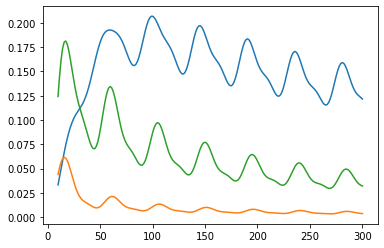

In [6]:
omgs = np.linspace(10, 300, 200)
v = [find_efficiency2(g_ratios[-3], omg,times[6]) for omg in omgs]
u = [find_efficiency2(g_ratios[-10], omg,times[6]) for omg in omgs]
w = [find_efficiency2(g_ratios[5], omg,times[6]) for omg in omgs]
plt.plot(omgs, v)
plt.plot(omgs, w)
plt.plot(omgs, u)

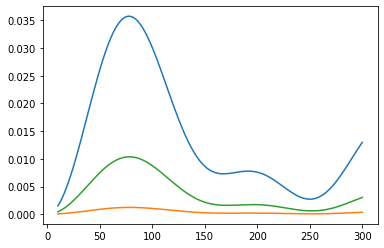

In [11]:
omgs = np.linspace(10, 300, 200)
timey = times[0]
v3 = [find_efficiency2(g_ratios[-3], omg,timey) for omg in omgs]
u3 = [find_efficiency2(g_ratios[-10], omg,timey) for omg in omgs]
w3 = [find_efficiency2(g_ratios[5], omg,timey) for omg in omgs]
plt.plot(omgs, v3)
plt.plot(omgs, w3)
plt.plot(omgs, u3)
plt.xlabel('$\Omega$')
plt.ylabel('$\eta$')

In [ ]:
plt.plot(omgs, w3)

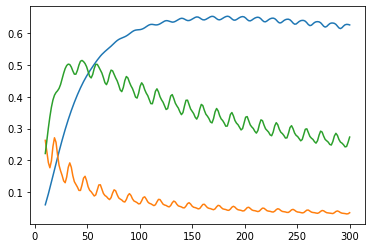

In [12]:
omgs = np.linspace(10, 300, 200)
timey = times[10]
v4 = [find_efficiency2(g_ratios[-3], omg,timey) for omg in omgs]
u4 = [find_efficiency2(g_ratios[-10], omg,timey) for omg in omgs]
w4 = [find_efficiency2(g_ratios[5], omg,timey) for omg in omgs]
plt.plot(omgs, v4)
plt.plot(omgs, w4)
plt.plot(omgs, u4)

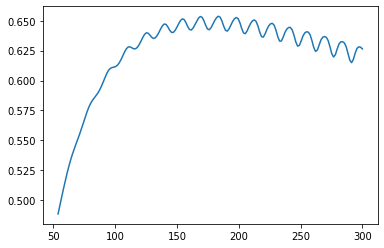

In [22]:
omgs = np.linspace(10, 300, 200)
plt.plot(omgs[30:], v4[30:])

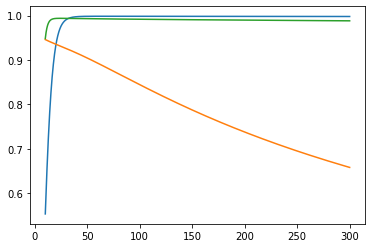

In [13]:
omgs = np.linspace(10, 300, 2000)
v2 = [find_efficiency2(g_ratios[-3], omg,times[-6]) for omg in omgs]
u2 = [find_efficiency2(g_ratios[-10], omg,times[-6]) for omg in omgs]
w2 = [find_efficiency2(g_ratios[5], omg,times[-6]) for omg in omgs]
plt.plot(omgs, v2)
plt.plot(omgs, w2)
plt.plot(omgs, u2)

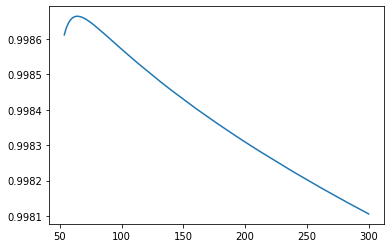

In [19]:
plt.plot(omgs[300:],v2[300:])

Text(0.5, 1.0, 'T = 0.1/$\\gamma$')

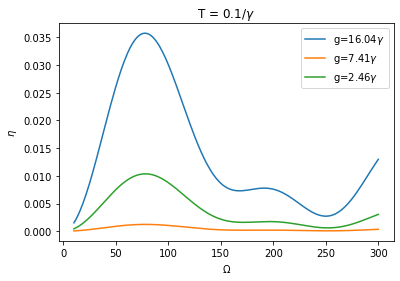

In [28]:
omgs = np.linspace(10, 300, 200)
plt.plot(omgs, v3)
plt.plot(omgs, w3)
plt.plot(omgs, u3)
plt.xlabel('$\Omega$')
plt.ylabel('$\eta$')
plt.legend([f'g={round(g_ratios[-3],2)}$\gamma$',f'g={round(g_ratios[-10],2)}$\gamma$',f'g={round(g_ratios[5],2)}$\gamma$'])
plt.title(f'T = {times[0]}/$\gamma$')

Text(0.5, 1.0, 'T = 0.56/$\\gamma$')

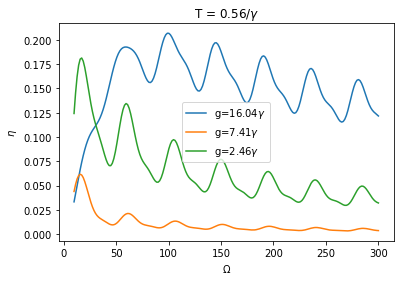

In [32]:
omgs = np.linspace(10, 300, 200)
plt.plot(omgs, v)
plt.plot(omgs, w)
plt.plot(omgs, u)
plt.xlabel('$\Omega$')
plt.ylabel('$\eta$')
plt.legend([f'g={round(g_ratios[-3],2)}$\gamma$',f'g={round(g_ratios[-10],2)}$\gamma$',f'g={round(g_ratios[5],2)}$\gamma$'])
plt.title(f'T = {round(times[6],2)}/$\gamma$')

Text(0.5, 1.0, 'T = 1.78/$\\gamma$')

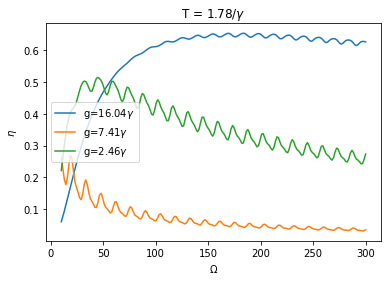

In [33]:
omgs = np.linspace(10, 300, 200)
plt.plot(omgs, v4)
plt.plot(omgs, w4)
plt.plot(omgs, u4)
plt.xlabel('$\Omega$')
plt.ylabel('$\eta$')
plt.legend([f'g={round(g_ratios[-3],2)}$\gamma$',f'g={round(g_ratios[-10],2)}$\gamma$',f'g={round(g_ratios[5],2)}$\gamma$'])
plt.title(f'T = {round(times[10],2)}/$\gamma$')

Text(0.5, 1.0, 'T = 23.71/$\\gamma$')

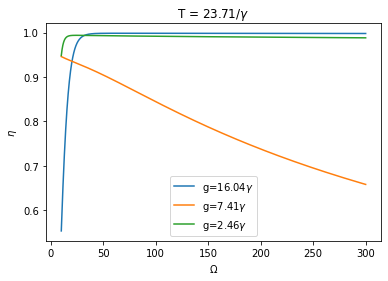

In [34]:
omgs = np.linspace(10, 300, 2000)
plt.plot(omgs, v2)
plt.plot(omgs, w2)
plt.plot(omgs, u2)
plt.xlabel('$\Omega$')
plt.ylabel('$\eta$')
plt.legend([f'g={round(g_ratios[-3],2)}$\gamma$',f'g={round(g_ratios[-10],2)}$\gamma$',f'g={round(g_ratios[5],2)}$\gamma$'])
plt.title(f'T = {round(times[-6],2)}/$\gamma$')

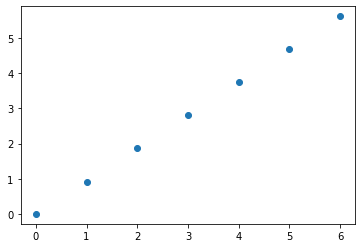

In [35]:
x=[0,1,2,3,4,5,6]
y=[0, 0.9, 1.86, 2.805, 3.75, 4.69, 5.62]
plt.plot(x,y,'o')

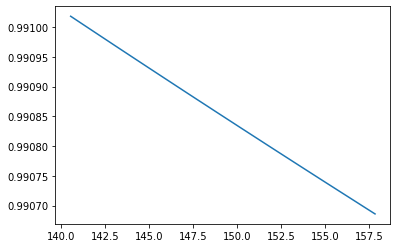

In [15]:
plt.plot(omgs[900:1020], u2[900:1020])

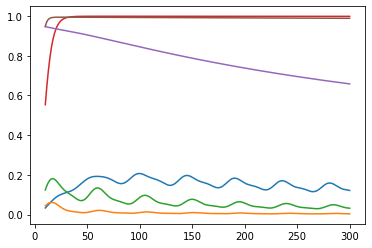

In [7]:
omgs = np.linspace(10, 300, 200)
v = [find_efficiency2(g_ratios[5], omg,times[-1]) for omg in omgs]
w = [find_efficiency2(g_ratios[-3], omg,times[-1]) for omg in omgs]
plt.plot(omgs, v)
plt.plot(omgs, w)

In [9]:
print(times[6], g_ratios[-1])

0.5623413251903491 20.000000000000004


In [19]:
all_outputs = []
for data_set in output_list:
    sub_omgs = []
    sub_delts = []
    sub_effs = []
    for data in data_set:
        sub_omgs.append(data['omega'])
        sub_delts.append(data['delta'])
        sub_effs.append(data['efficiency'])
    all_outputs.append({
        'omegas': sub_omgs,
        'deltas': sub_delts,
        'efficiencies': sub_effs
    })

final_data = [g_ratios, times, all_outputs]
save_obj(final_data, 'time-varying sin^2 2D, kappa=1gamma, gamma=2pi')

time-varying sin^2 2D, kappa=1gamma, gamma=2pi.pickle


Text(0.5, 1.0, '$\\gamma=2\\pi$, $\\sin^2$ pulse, $kappa=\\gamma$')

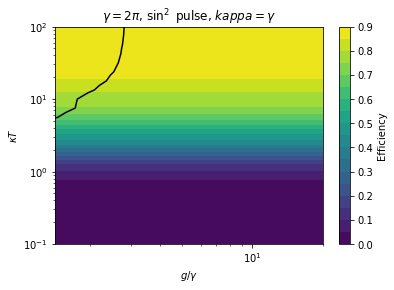

In [20]:
X, Y = np.meshgrid(g_ratios, times)
num_contours = 20

grand_efficiencies = [all_outputs[k]['efficiencies'] for k in range(len(all_outputs))]

fig, axes = plt.subplots(1,1)
cp = axes.contourf(X,Y, grand_efficiencies, levels = num_contours)

axes.set_xscale('log')
axes.set_yscale('log')

cbar = fig.colorbar(cp)
cbar.set_label('Efficiency')

bench_effs = []
for ratio in g_ratios:
    C = ratio**2*gamma/(2*kappa)
    bench_effs.append(2*C/(2*C+1))

grand_bench_effs = [bench_effs for j in range(len(times))]

grand_diffs = []
for j in range(len(times)):
    diff_effs = [grand_efficiencies[j][k] - grand_bench_effs[j][k] for k in range(len(g_ratios))]
    grand_diffs.append(diff_effs)

cont = axes.contour(X,Y,grand_diffs,[0], colors = 'k')
axes.set_xlabel('$g/\gamma$')
axes.set_ylabel('$\kappa T$')
axes.set_title('$\gamma=2\pi$, $\sin^2$ pulse, $kappa=\gamma$')

In [25]:
cp = axes.contourf(X,Y, grand_diffs, levels = num_contours)

axes.set_xscale('log')
axes.set_yscale('log')

cbar = fig.colorbar(cp)
cbar.set_label('Efficiency Difference with Benchmark')
cont = axes.contour(X,Y,grand_diffs,[0], colors = 'k')
axes.set_xlabel('$g/\gamma$')
axes.set_ylabel('$\kappa T$')
axes.set_title('$\gamma=2\pi$, $\sin^2$ pulse, $kappa=\gamma$')

Text(0.5, 1.0, '$\\gamma=2\\pi$, $\\sin^2$ pulse, $kappa=\\gamma$')

In [22]:
print([[0,0,0]]*3)

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]


In [23]:
v = [1,2,3]
try:
    print(v[3])
except:
    v.append(4)

print(v)

[1, 2, 3, 4]


In [24]:
v=[[0,0,0],[0,0,0],[0,0,0]]
print(v)
print(v[1][2])
v[1][2] = 4
print(v)

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
0
[[0, 0, 0], [0, 0, 4], [0, 0, 0]]


In [17]:
v=[[0,0,0]]*3
print(v)
print(v[1][2])
v[1][2] = 4
print(v)

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]
0
[[0, 0, 4], [0, 0, 4], [0, 0, 4]]
